In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import Image

In [3]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 29.0 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 132 kB 69.8 MB/s 
     |████████████████████████████████| 79 kB 10.7 MB/s 
     |████████████████████████████████| 8.9 MB 60.7 MB/s 
     |████████████████████████████████| 138 kB 76.7 MB/s 
     |████████████████████████████████| 127 kB 75.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 27.3 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 6.6 MB 64.5 MB/s 


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Thu Jun 30 05:40:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
device

device(type='cuda')

In [52]:
df = pd.read_csv('/content/drive/MyDrive/Task6/merged_file.csv')
df.head()

,0,1,2,3
0,AI_101_result_slice_0,चेकप करवाया है उन्होंने उसको दिया था ब्लड चेकउ...,"They have got the checkup done, they had given...",2
1,NaN,"बस यही दवाई खाई है 1.6 महीने से, ये कभी नहीं ख...",Just this medicine has been eaten from 1.6 mon...,1
2,NaN,पहले नहीं नहीं हुआ कभी बस ये 1.6 महीने में हुई...,Never not happened before it has happened in 1...,2
3,NaN,ये लोकदोन में ऐसा काम वाम था नहीं टेंशन हो गई ...,"This was such a work in Lokdon, not tension ha...",1
4,NaN,तो उससे क्या है दिमाग की डिप्रेशन हो गयी है या...,So what is the depression of the brain from it...,1


In [53]:
df.drop("1", axis=1, inplace=True)
df.head()
print(len(df['2']))

2489


In [54]:
df.drop("0", axis=1, inplace=True)
df.head()

,2,3
0,"They have got the checkup done, they had given...",2
1,Just this medicine has been eaten from 1.6 mon...,1
2,Never not happened before it has happened in 1...,2
3,"This was such a work in Lokdon, not tension ha...",1
4,So what is the depression of the brain from it...,1


In [55]:
df.rename(columns = {'2':'english_text', '3' :'label'}, inplace = True)
df.head()

,english_text,label
0,"They have got the checkup done, they had given...",2
1,Just this medicine has been eaten from 1.6 mon...,1
2,Never not happened before it has happened in 1...,2
3,"This was such a work in Lokdon, not tension ha...",1
4,So what is the depression of the brain from it...,1


In [56]:
#df['label'] = df['label'].replace([0,1,2],['intro','emotional', 'grey'])
#df.head()

In [57]:
type(df['label'][0])

numpy.int64

In [58]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.english_text.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [59]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print(tokenized_texts[0])
print (len(tokenized_texts[0]))

Tokenize the first sentence:
['[CLS]', 'they', 'have', 'got', 'the', 'check', '##up', 'done', ',', 'they', 'had', 'given', 'blood', 'check', '##up', 'to', 'him', '[SEP]']
18


In [60]:
#Processing the data
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(len(input_ids[0]))
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(len(input_ids[0]))

18
128


In [85]:
#Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(type(input_ids))
train_ids = input_ids[0:-500]
train_label = labels[0:-500]
test_ids = input_ids[-500:]
test_label = labels[-500:]
train_attention_masks = attention_masks[0:-500]
test_attention_masks = attention_masks[-500:]
print(len(train_label))
print(len(test_attention_masks))
print(len(train_ids))

<class 'numpy.ndarray'>
1989
500
1989


In [70]:
# Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_ids, train_label,random_state = 2018, test_size = 0.1 )
train_masks, validation_masks, _, _ = train_test_split(train_attention_masks, train_ids,
                                             random_state=2018, test_size=0.1)

In [71]:
type(validation_masks)

list

In [72]:
#Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
print(type(train_inputs))

<class 'torch.Tensor'>


In [74]:
# Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
print(len(train_inputs))
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

1790


In [75]:
# Bert Model Configuration
# Initializing a BERT bert-base-uncased style configuration
# Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
# This process will load only configuration and not the weights associated with the model
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [76]:
# Loading the Hugging Face Bert Uncased Base Model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model = nn.DataParallel(model)
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

In [77]:
# Optimizer Grouped Parameters
# reference:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

In [78]:
# The Hyperparameters for the Training Loop 

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0.1, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [79]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [80]:
# The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.9305115049438817


Epoch:  10%|█         | 1/10 [00:36<05:32, 36.92s/it]

Validation Accuracy: 0.7087912087912087
Train loss: 0.6655197319175515


Epoch:  20%|██        | 2/10 [01:15<05:03, 37.88s/it]

Validation Accuracy: 0.7410714285714286
Train loss: 0.41962036517049583


Epoch:  30%|███       | 3/10 [01:55<04:31, 38.73s/it]

Validation Accuracy: 0.7218406593406593
Train loss: 0.21676879226496176


Epoch:  40%|████      | 4/10 [02:34<03:53, 38.84s/it]

Validation Accuracy: 0.7218406593406593
Train loss: 0.12692739338880138


Epoch:  50%|█████     | 5/10 [03:13<03:15, 39.10s/it]

Validation Accuracy: 0.7074175824175823
Train loss: 0.0868369422304178


Epoch:  60%|██████    | 6/10 [03:52<02:36, 39.11s/it]

Validation Accuracy: 0.6833791208791209
Train loss: 0.06395499740860291


Epoch:  70%|███████   | 7/10 [04:32<01:57, 39.16s/it]

Validation Accuracy: 0.7122252747252747
Train loss: 0.04865558010975032


Epoch:  80%|████████  | 8/10 [05:11<01:18, 39.19s/it]

Validation Accuracy: 0.7218406593406593
Train loss: 0.03756868647178635


Epoch:  90%|█████████ | 9/10 [05:50<00:39, 39.19s/it]

Validation Accuracy: 0.7122252747252747
Train loss: 0.03454810178871932


Epoch: 100%|██████████| 10/10 [06:29<00:00, 38.97s/it]

Validation Accuracy: 0.717032967032967


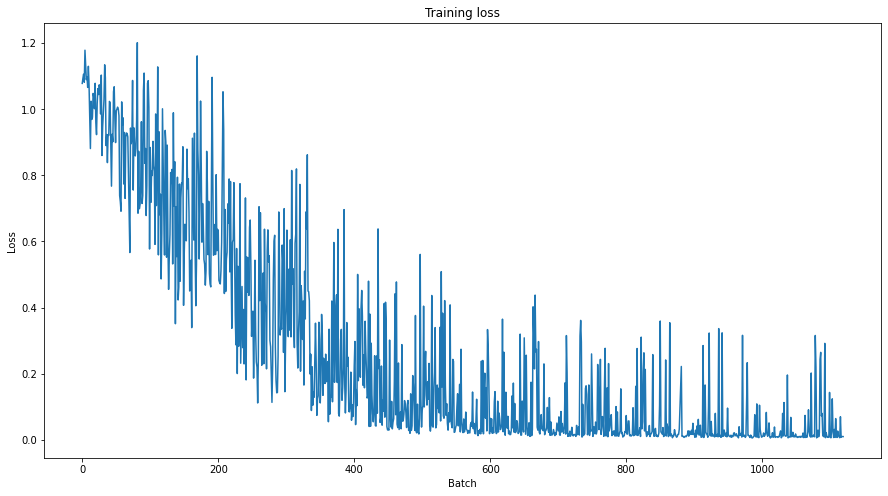

In [81]:
# Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


In [86]:
prediction_inputs = torch.tensor(test_ids)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_label)
  
batch_size = 32  
print(len(test_ids))
print(len(test_attention_masks))
print(len(test_label))

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

500
500
500


In [87]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [88]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [89]:
#@title Score of Individual Batches
matthews_set

[0.4363589673350946,
 0.30550471998893036,
 0.31277162108561213,
 0.29914280640838503,
 0.10620880867361726,
 0.3780537524419143,
 0.3995020291221036,
 0.2982823443553751,
 0.1872532903259791,
 0.43970778420733186,
 0.2157417422366347,
 0.4531243958672577,
 0.2872482885273913,
 0.28578699785818873,
 0.39160432210367585,
 0.3399873495432769]

In [90]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.34267626753953223